In [1]:
import os
import logging
import shutil
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
main_directory = os.path.sep.join(path_components[:-1])
code_directory = os.path.join(main_directory,'code')
sys.path.insert(0,code_directory)
print(sys.path)

['c:\\Users\\achom\\Desktop\\Main\\Code\\Scientific-Computing\\Physics-Neural-Networks\\PINN\\code', 'c:\\Users\\achom\\Desktop\\Main\\Code\\Scientific-Computing\\Physics-Neural-Networks\\PINN\\tutorials', 'C:\\Users\\achom\\AppData\\Local\\Programs\\Python\\Python38\\python38.zip', 'C:\\Users\\achom\\AppData\\Local\\Programs\\Python\\Python38\\DLLs', 'C:\\Users\\achom\\AppData\\Local\\Programs\\Python\\Python38\\lib', 'C:\\Users\\achom\\AppData\\Local\\Programs\\Python\\Python38', 'c:\\Users\\achom\\Desktop\\Main\\Code\\Scientific-Computing\\Physics-Neural-Networks\\PINN\\.venv', '', 'c:\\Users\\achom\\Desktop\\Main\\Code\\Scientific-Computing\\Physics-Neural-Networks\\PINN\\.venv\\lib\\site-packages', 'c:\\Users\\achom\\Desktop\\Main\\Code\\Scientific-Computing\\Physics-Neural-Networks\\PINN\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\achom\\Desktop\\Main\\Code\\Scientific-Computing\\Physics-Neural-Networks\\PINN\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\achom\\Desktop

In [2]:
from Mesh.Molecule_Mesh import Molecule_Mesh
from Model.PDE_Model import PBE
from NN.NeuralNet import NeuralNet
from NN.PINN import PINN 
from NN.XPINN import XPINN

simulation_name = "Tutorial"
main_path = os.getcwd()
folder_name = simulation_name
folder_path = os.path.join(main_path,'results',folder_name)
if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
os.makedirs(folder_path)

filename = os.path.join(folder_path,'logfile.log')
LOG_format = '%(levelname)s - %(name)s: %(message)s'
logging.basicConfig(filename=filename, filemode='w', level=logging.INFO, format=LOG_format)
logger = logging.getLogger(__name__)
logger.info('==============================================')

In [7]:
from Mesh.Mesh_utils import generate_msms_mesh
from Mesh.Charges_utils import convert_pqr2xyzr

molecule = 'born_ion'
path_pqr = os.path.join(code_directory,'Molecules',molecule,f'{molecule}.pqr')
path_xyzr = os.path.join(code_directory,'Molecules',molecule,f'{molecule}.xyzr')
mesh_dir = 'results'

convert_pqr2xyzr(path_pqr, path_xyzr,for_mesh=True)
generate_msms_mesh(path_xyzr, mesh_dir, molecule, density=2)

c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\code\Mesh\Mesh_softwares\MSMS\msms.exe -if c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\code\Molecules\born_ion\born_ion.xyzr -of results\born_ion_d2 -p 1.4 -d 2 -no_header


In [6]:

inputs = {'molecule': 'born_ion',
                'epsilon_1':  1,
                'epsilon_2': 80,
                'kappa': 0.125,
                'T' : 300 
                }

N_points = {'dx_interior': 0.4,
                'dx_exterior': 2.5,
                'N_border': 6,
                'dR_exterior': 5,
                'dx_experimental': 2.0,
                'N_pq': 10,
                'G_sigma': 0.04,
                'mesh_density': 3
                }

Mol_mesh = Molecule_Mesh(inputs['molecule'], 
                N_points=N_points, 
                simulation=simulation_name,
                path=code_directory, # path to the mesh
                plot=True,
                result_path=main_path # path to results
                )

PBE_model = PBE(inputs,
        mesh=Mol_mesh, 
        model='linear',
        path=code_directory  # path to molecule files
        ) 

meshes_in = dict()
meshes_in['1'] = {'type':'R', 'value':None, 'fun':lambda x,y,z: PBE_model.source(x,y,z)}
meshes_in['2'] = {'type':'Q', 'value':None, 'fun':lambda x,y,z: PBE_model.source(x,y,z)}
meshes_in['3'] = {'type':'K', 'value':None, 'fun':None, 'file':'data_known.dat'}
#meshes_in['4'] = {'type':'P', 'value':None, 'fun':None, 'file':'data_precond.dat'}

PBE_model.PDE_in.mesh.adapt_meshes(meshes_in)

meshes_out = dict()
meshes_out['1'] = {'type':'R', 'value':0.0, 'fun':None}
meshes_out['2'] = {'type':'D', 'value':None, 'fun':lambda x,y,z: PBE_model.border_value(x,y,z)}
meshes_out['3'] = {'type':'K', 'value':None, 'fun':None, 'file':'data_known.dat'}
#meshes_out['4'] = {'type':'P', 'value':None, 'fun':None, 'file':'data_precond.dat'}
PBE_model.PDE_out.mesh.adapt_meshes(meshes_out)

meshes_domain = dict()
meshes_domain['1'] = {'type':'I', 'value':None, 'fun':None}
meshes_domain['2'] = {'type': 'E', 'file': 'data_experimental.dat'}
#meshes_domain['3'] = {'type':'G', 'value':None, 'fun':None}
PBE_model.mesh.adapt_meshes_domain(meshes_domain,PBE_model.q_list)

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs(PBE_model)


Mesh initialization ready
PDEs and datasets ready


In [7]:
weights = {'w_r': 1,
                'w_d': 1,
                'w_n': 1,
                'w_i': 1,
                'w_k': 1,
                'w_e': 1,
                'w_g': 1
                }

XPINN_solver.adapt_weights([weights,weights],
                                adapt_weights = True,
                                adapt_w_iter = 5,
                                adapt_w_method = 'gradients',
                                alpha = 0.7)             

hyperparameters_in = {
                'input_shape': (None,3),
                'num_hidden_layers': 2,
                'num_neurons_per_layer': 20,
                'output_dim': 1,
                'activation': 'tanh',
                'architecture_Net': 'FCNN',
                'fourier_features': True,
                'num_fourier_features': 128
        }

hyperparameters_out = {
                'input_shape': (None,3),
                'num_hidden_layers': 2,
                'num_neurons_per_layer': 20,
                'output_dim': 1,
                'activation': 'tanh',
                'architecture_Net': 'FCNN',
                'fourier_features': False
        }

XPINN_solver.create_NeuralNets(NeuralNet,[hyperparameters_in,hyperparameters_out])

XPINN_solver.set_points_methods(
        sample_method='batches', 
        N_batches=1, 
        sample_size=50)

optimizer = 'Adam'
lr_s = ([1000,1600],[1e-2,5e-3,5e-4])
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(*lr_s)
lr = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=2000,
        decay_rate=0.9,
        staircase=True)
lr_p = 0.001
XPINN_solver.adapt_optimizers(optimizer,[lr,lr],lr_p)

In [8]:
N_iters = 14

precondition = False
N_precond = 100

iters_save_model = 0
XPINN_solver.folder_path = folder_path

XPINN_solver.solve(N=N_iters, 
                precond = precondition, 
                N_precond = N_precond,  
                save_model = iters_save_model, 
                G_solve_iter=5)

Loss: 1.0000e+02:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 1.9626e+05: 100%|██████████| 14/14 [01:42<00:00,  7.32s/it]


In [10]:
from Post.Postcode import Born_Ion_Postprocessing as Postprocessing
Post = Postprocessing(XPINN_solver, save=True, directory=folder_path)

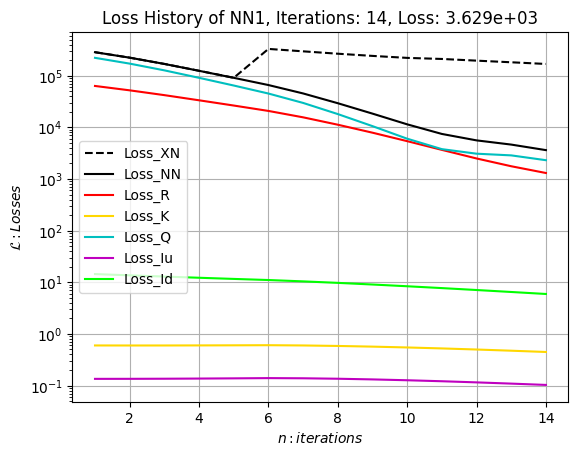

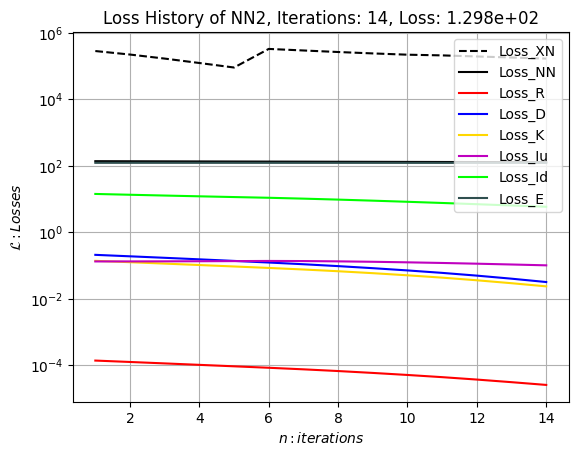

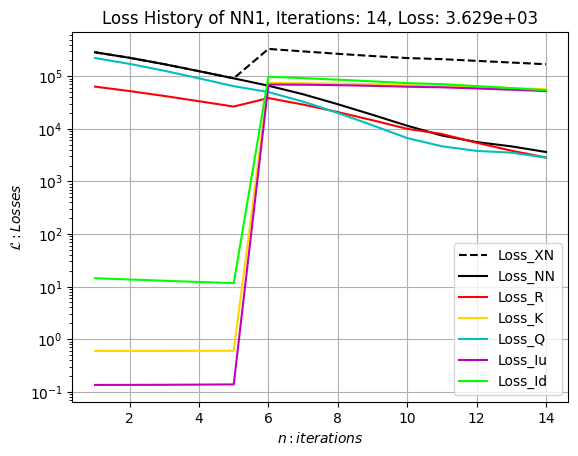

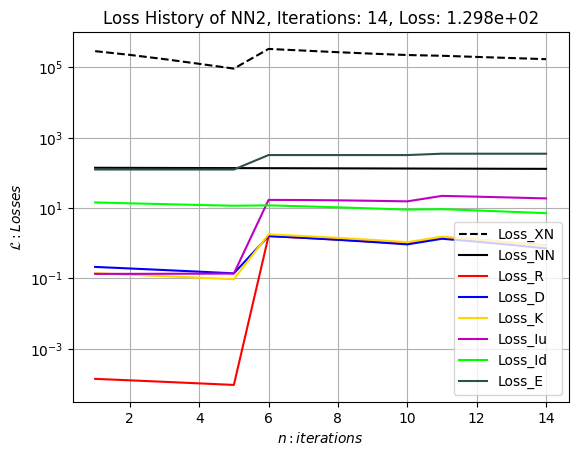

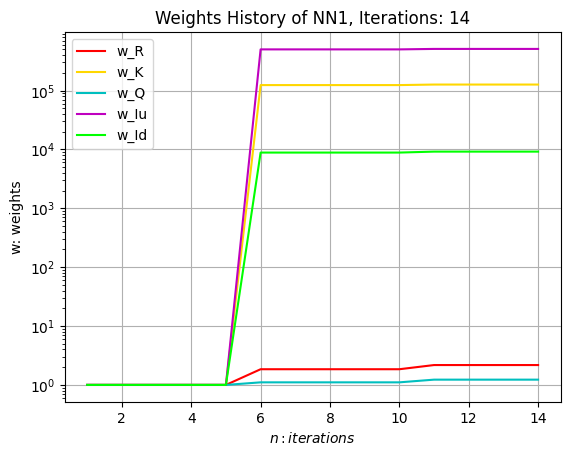

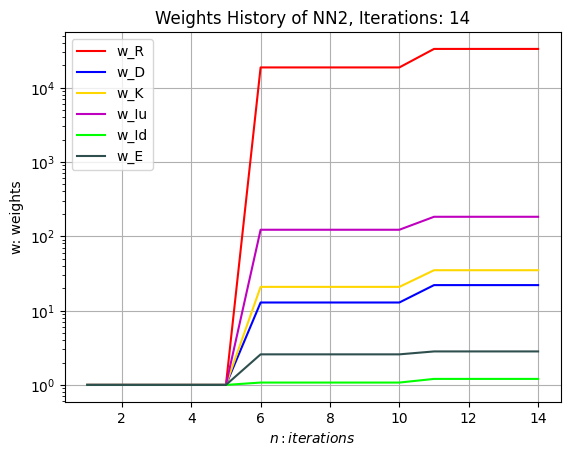

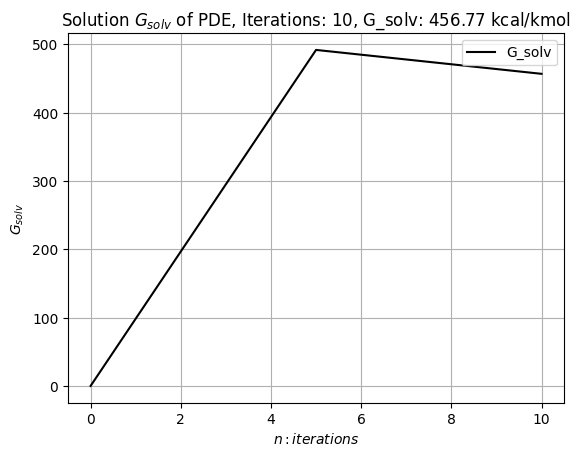

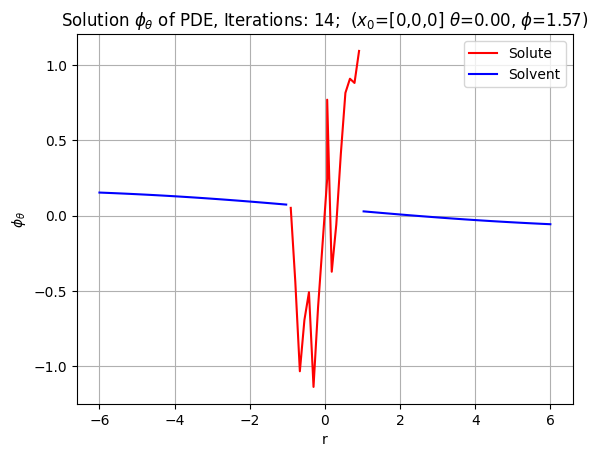

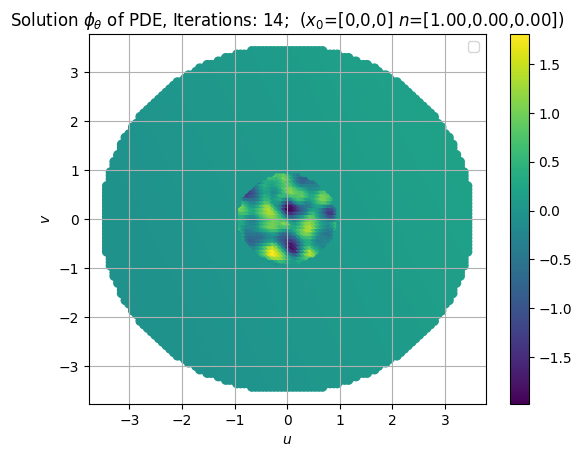

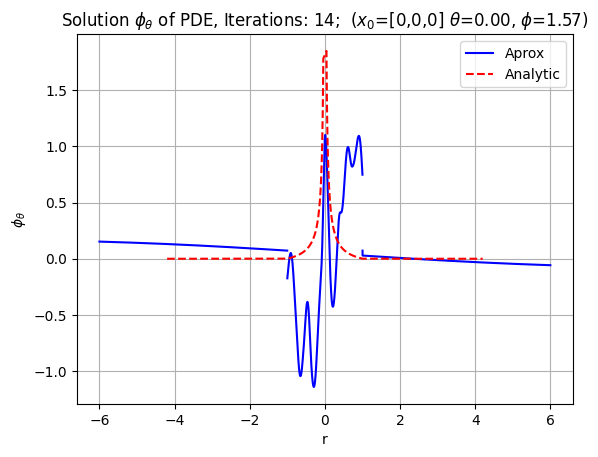

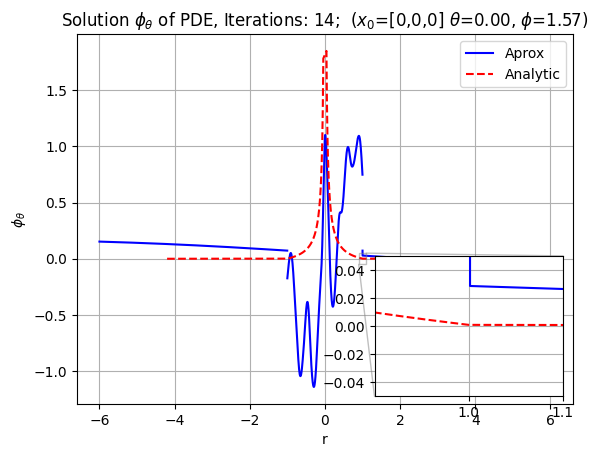

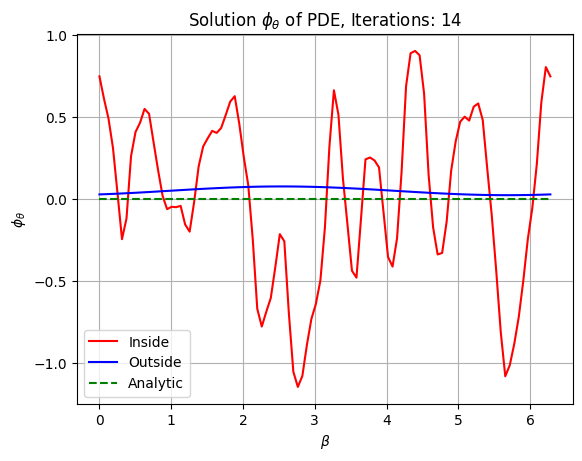

In [11]:

Post.plot_loss_history(domain=1);
Post.plot_loss_history(domain=2);
Post.plot_loss_history(domain=1, plot_w=True);
Post.plot_loss_history(domain=2, plot_w=True);
Post.plot_weights_history(domain=1);
Post.plot_weights_history(domain=2);


Post.plot_G_solv_history();
Post.plot_collocation_points_3D();
Post.plot_mesh_3D();
Post.plot_interface_3D(variable='phi');
Post.plot_interface_3D(variable='dphi');
Post.plot_phi_line();
Post.plot_phi_contour();
Post.plot_aprox_analytic();
Post.plot_aprox_analytic(zoom=True);
Post.plot_line_interface();
Post.save_values_file();

Post.plot_architecture(domain=1);
Post.plot_architecture(domain=2);